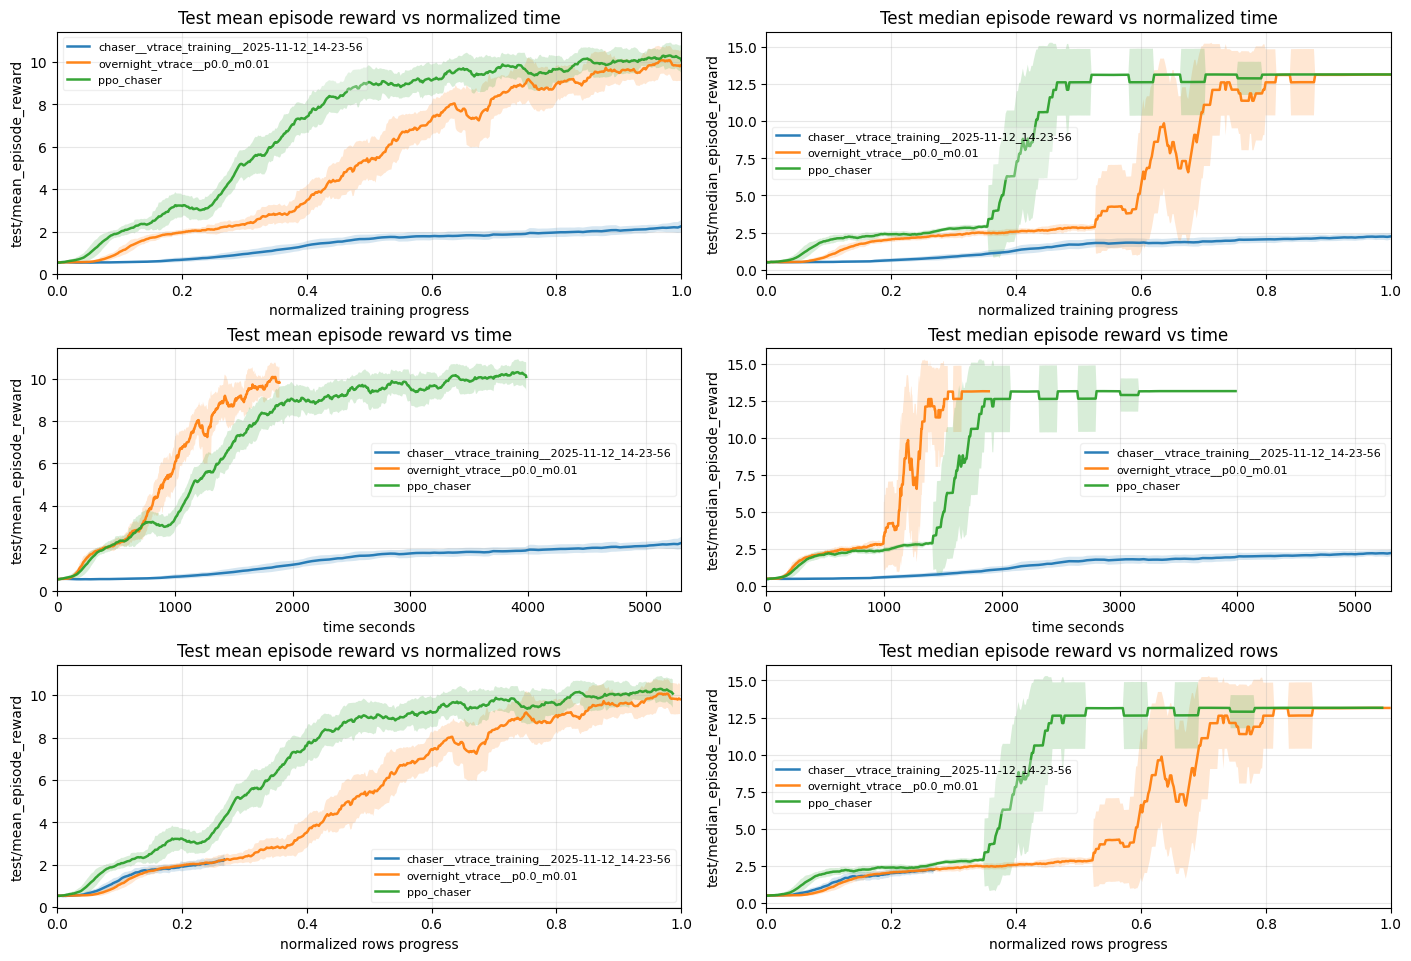

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"

TIME_CANDIDATES = ["time", "timestamp", "wall_time", "train/total_time", "training_time"]
STEP_CANDIDATES = ["step", "global_step", "steps", "train/steps", "train/global_step", "num_timesteps", "timesteps"]

Y_MEAN = "test/mean_episode_reward"
Y_MEDIAN = "test/median_episode_reward"
Y_MEAN_ALIASES = [Y_MEAN, "test/mean_reward"]
Y_MEDIAN_ALIASES = [Y_MEDIAN, "test/median_reward"]

PLOTS = [
    {"x": "t_norm", "y": Y_MEAN, "xlabel": "normalized training progress", "ylabel": Y_MEAN, "title": "Test mean episode reward vs normalized time"},
    {"x": "t_norm", "y": Y_MEDIAN, "xlabel": "normalized training progress", "ylabel": Y_MEDIAN, "title": "Test median episode reward vs normalized time"},
    {"x": "t", "y": Y_MEAN, "xlabel": "time seconds", "ylabel": Y_MEAN, "title": "Test mean episode reward vs time"},
    {"x": "t", "y": Y_MEDIAN, "xlabel": "time seconds", "ylabel": Y_MEDIAN, "title": "Test median episode reward vs time"},
    {"x": "rows_norm", "y": Y_MEAN, "xlabel": "normalized rows progress", "ylabel": Y_MEAN, "title": "Test mean episode reward vs normalized rows"},
    {"x": "rows_norm", "y": Y_MEDIAN, "xlabel": "normalized rows progress", "ylabel": Y_MEDIAN, "title": "Test median episode reward vs normalized rows"},
]

ROLL_WINDOW = 20
UNCERTAINTY_SCALE = 1.0
BAND_ALPHA = 0.18

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")
logger = logging.getLogger("sit_plot")

def find_run_csvs(root, csv_name):
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    paths = sorted(paths)
    if not paths:
        logger.warning(f"No CSVs named '{csv_name}' found under root='{root}'")
    return paths

def infer_run_name(path, root):
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def to_seconds(series, context=""):
    if series is None:
        logger.warning(f"{context} time series is None")
        return None
    if pd.api.types.is_numeric_dtype(series):
        v = pd.to_numeric(series, errors="coerce").astype(float).values
        if not np.isfinite(v).any():
            logger.warning(f"{context} numeric time column has no finite values; will fallback")
        return v
    parsed = pd.to_datetime(series, errors="coerce", utc=True)
    if parsed.notna().any():
        v = parsed.view("int64") / 1e9
        if not np.isfinite(v).any():
            logger.warning(f"{context} parsed datetime column has no finite values; will fallback")
        return v
    s = series.astype(str)
    if s.str.contains(":").any():
        def parse_duration(x):
            try:
                parts = [float(p) for p in str(x).split(":")]
                if len(parts) == 3:
                    return parts[0]*3600 + parts[1]*60 + parts[2]
                if len(parts) == 2:
                    return parts[0]*60 + parts[1]
            except:
                return np.nan
            return np.nan
        v = s.map(parse_duration).values
        if not np.isfinite(v).any():
            logger.warning(f"{context} duration-like time column could not be parsed; will fallback")
        return v
    v = pd.to_numeric(series, errors="coerce").values
    if not np.isfinite(v).any():
        logger.warning(f"{context} generic numeric parse produced no finite values; will fallback")
    return v

def pick_time_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def build_time_seconds(df, run_ctx=""):
    tcol = pick_time_column(df, TIME_CANDIDATES)
    if tcol is not None:
        t = to_seconds(df[tcol], context=f"[{run_ctx}] time='{tcol}':")
    elif "train/total_time" in df.columns:
        t = to_seconds(df["train/total_time"], context=f"[{run_ctx}] time='train/total_time':")
    else:
        t = np.arange(len(df), dtype=float)
    if t is None or np.all(~np.isfinite(t)):
        t = np.arange(len(df), dtype=float)
    t = np.array(t, dtype=float)
    if np.isfinite(t).any():
        t0 = np.nanmin(t)
        if np.isfinite(t0) and t0 != 0:
            t = t - t0
    return t

def normalize_time_per_run(t, df, run_ctx=""):
    if "train/total_time" in df.columns:
        total = np.nanmax(to_seconds(df["train/total_time"], context=f"[{run_ctx}] total_time:"))
    else:
        total = np.nanmax(t)
    if not np.isfinite(total) or total <= 0:
        total = np.nanmax(t)
    if not np.isfinite(total) or total <= 0:
        total = 1.0
    return np.clip(t / float(total), 0.0, np.inf)

def build_steps(df, run_ctx=""):
    col = None
    for c in STEP_CANDIDATES:
        if c in df.columns:
            col = c
            break
    if col is None:
        steps = np.arange(len(df), dtype=float)
    else:
        steps = pd.to_numeric(df[col], errors="coerce").astype(float).values
        if steps is None or np.all(~np.isfinite(steps)):
            steps = np.arange(len(df), dtype=float)
    steps = np.array(steps, dtype=float)
    if np.isfinite(steps).any():
        s0 = np.nanmin(steps)
        if np.isfinite(s0):
            steps = steps - s0
    return steps

def get_first_present(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

def load_runs(root):
    paths = find_run_csvs(root, CSV_NAME)
    data = []
    if not paths:
        logger.error("No valid runs loaded after filtering")
        return pd.DataFrame()
    max_rows_across_runs = 1
    for p in paths:
        run = infer_run_name(p, root)
        try:
            df_tmp = pd.read_csv(p)
        except Exception as e:
            logger.error(f"[{run}] failed to read CSV '{p}': {e}")
            continue
        n = len(df_tmp)
        if n > max_rows_across_runs:
            max_rows_across_runs = n
    for p in paths:
        run = infer_run_name(p, root)
        try:
            df = pd.read_csv(p)
        except Exception as e:
            logger.error(f"[{run}] failed to read CSV '{p}': {e}")
            continue
        y_mean_col = get_first_present(df, Y_MEAN_ALIASES)
        y_median_col = get_first_present(df, Y_MEDIAN_ALIASES)
        if y_mean_col is None and y_median_col is None:
            logger.warning(f"[{run}] missing target columns; looked for {Y_MEAN_ALIASES} and {Y_MEDIAN_ALIASES}; skipping")
            continue
        t = build_time_seconds(df, run_ctx=run)
        tn = normalize_time_per_run(t, df, run_ctx=run)
        steps = build_steps(df, run_ctx=run)
        row_idx = np.arange(len(df), dtype=float)
        rows_norm = np.clip(row_idx / float(max_rows_across_runs), 0.0, np.inf)
        sub = pd.DataFrame({
            "run": run,
            "t": t,
            "t_norm": tn,
            "steps": steps,
            "rows_norm": rows_norm,
            Y_MEAN: pd.to_numeric(df.get(y_mean_col, np.nan), errors="coerce"),
            Y_MEDIAN: pd.to_numeric(df.get(y_median_col, np.nan), errors="coerce"),
        })
        sub = sub.sort_values("t_norm")
        if sub[Y_MEAN].isna().all() and sub[Y_MEDIAN].isna().all():
            logger.warning(f"[{run}] both '{Y_MEAN}' and '{Y_MEDIAN}' are NaN for all rows; run will not appear in plots")
        data.append(sub)
    if not data:
        logger.error("No valid runs loaded after filtering")
        return pd.DataFrame()
    return pd.concat(data, ignore_index=True)

def smooth_series(y):
    s = pd.Series(y, dtype=float)
    return s.rolling(ROLL_WINDOW, min_periods=1).mean().values

def uncertainty_series(y):
    s = pd.Series(y, dtype=float)
    std = s.rolling(ROLL_WINDOW, min_periods=1).std(ddof=1)
    v = std.bfill().ffill().values
    return v

def plot_runs(ax, df, runs, x, y, xlabel, ylabel, title):
    plotted_any = False
    for r in runs:
        d = df[df["run"] == r]
        if x == "t":
            d = d.sort_values("t")
        elif x == "steps":
            d = d.sort_values("steps")
        elif x == "rows_norm":
            d = d.sort_values("rows_norm")
        xv = d[x].values
        yv = d[y].values
        if np.all(np.isnan(yv)):
            logger.warning(f"[{r}] plot '{title}' y='{y}' has all NaN; skipping this line")
            continue
        ys = smooth_series(yv)
        u = uncertainty_series(yv) * UNCERTAINTY_SCALE
        ax.plot(xv, ys, label=r, linewidth=1.8, alpha=0.95)
        ax.fill_between(xv, ys - u, ys + u, alpha=BAND_ALPHA, linewidth=0)
        plotted_any = True
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if x == "t_norm":
        xmax = max(1.0, np.nanmax(df["t_norm"].values)) if np.isfinite(np.nanmax(df["t_norm"].values)) else 1.0
        ax.set_xlim(0, xmax)
    elif x == "t":
        xmax = np.nanmax(df["t"].values)
        if np.isfinite(xmax):
            ax.set_xlim(0, xmax)
    elif x == "steps":
        xmax = np.nanmax(df["steps"].values)
        if np.isfinite(xmax):
            ax.set_xlim(left=0)
    elif x == "rows_norm":
        ax.set_xlim(0, 1.0)
    ax.grid(True, alpha=0.3)
    if plotted_any:
        ax.legend(loc="best", fontsize=8, framealpha=0.3)
    else:
        logger.warning(f"Nothing plotted for '{title}' y='{y}' across all runs")

df = load_runs(ROOT_DIR)

if df.empty:
    print(f"No {CSV_NAME} files with test rewards found under: {ROOT_DIR}")
else:
    runs = df["run"].unique().tolist()
    rows, cols = 3, 2
    fig, axes = plt.subplots(rows, cols, figsize=(14, 9.5), constrained_layout=True)
    axes = axes.flatten()
    for i, cfg in enumerate(PLOTS):
        plot_runs(axes[i], df, runs, **cfg)
    for j in range(len(PLOTS), rows*cols):
        fig.delaxes(axes[j])
    plt.show()


WARNING | [chaser__vtrace_lr3.5/chaser__vtrace_training__2025-11-11_10-47-28_lr3.5] could not parse p/m from run name; got p=nan, m=nan
WARNING | [chaser__vtrace_new_dropout-0.01_clip-0.5] could not parse p/m from run name; got p=-0.5, m=nan
WARNING | [chaser__vtrace_training__2025-11-12_11-03-38] could not parse p/m from run name; got p=nan, m=nan
WARNING | [ppo_chaser] could not parse p/m from run name; got p=nan, m=nan


,run,p,m,mean_lastN_winsor,median_lastN_winsor
0,chaser__vtrace_lr3.5/chaser__vtrace_training__...,NaN,NaN,7.364087,6.3002
1,chaser__vtrace_new_dropout-0.01_clip-0.5,-0.5,NaN,2.224968,2.3174
2,chaser__vtrace_training__2025-11-12_11-03-38,NaN,NaN,2.304285,2.2934
3,overnight_vtrace__p0.0_m0.01,0.0,0.01,9.830247,13.1432
4,ppo_chaser,NaN,NaN,10.169733,13.1600


,p,m,mean_lastN_winsor,median_lastN_winsor
0,-0.5,0.01,NaN,NaN
1,0.0,0.01,9.830247,13.1432


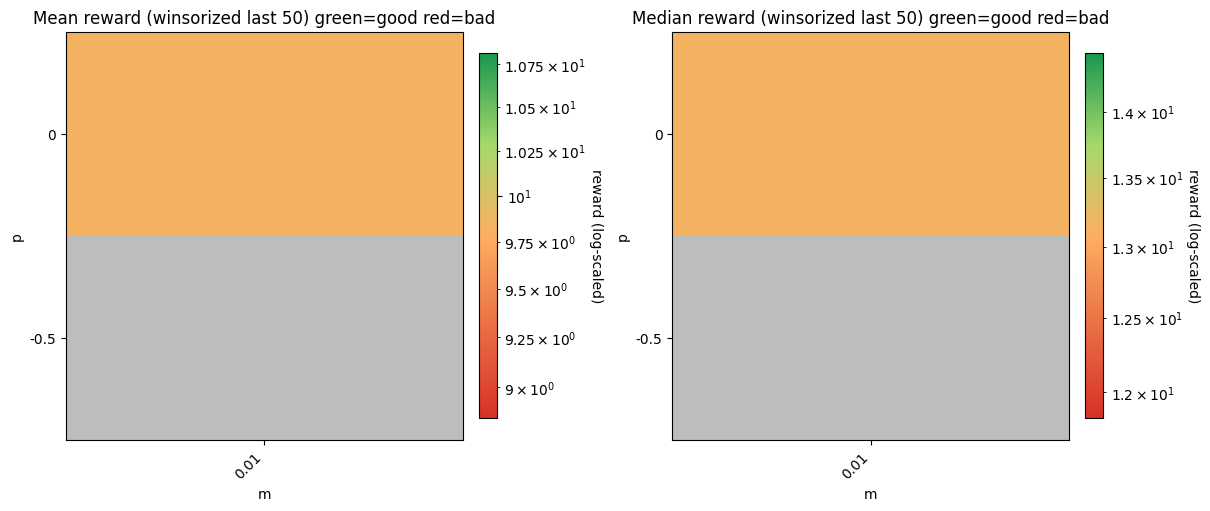

In [34]:
import os
import re
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm, SymLogNorm

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"

Y_MEAN = "test/mean_episode_reward"
Y_MEDIAN = "test/median_episode_reward"
Y_MEAN_ALIASES = [Y_MEAN, "test/mean_reward"]
Y_MEDIAN_ALIASES = [Y_MEDIAN, "test/median_reward"]

LAST_N = 50
WINSOR_Q = 0.10

logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")
logger = logging.getLogger("sit_matrix_nb")

def find_run_csvs(root, csv_name):
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    paths = sorted(paths)
    if not paths:
        logger.warning(f"No CSVs named '{csv_name}' found under root='{root}'")
    return paths

def infer_run_name(path, root):
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def parse_p_m_from_run(run_name):
    p_match = re.search(r"p([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    m_match = re.search(r"m([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)", run_name)
    p = float(p_match.group(1)) if p_match else np.nan
    m = float(m_match.group(1)) if m_match else np.nan
    if not np.isfinite(p) or not np.isfinite(m):
        logger.warning(f"[{run_name}] could not parse p/m from run name; got p={p}, m={m}")
    return p, m

def get_first_present(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

def _nan_masked_tail(series, n):
    x = pd.to_numeric(pd.Series(series), errors="coerce").dropna().values
    if x.size == 0:
        return x
    n_eff = min(n, x.size) if n is not None and n > 0 else x.size
    return x[-n_eff:]

def winsorized_mean_lastN(series, n, q):
    x = _nan_masked_tail(series, n)
    if x.size == 0:
        return np.nan
    if x.size < 3:
        return float(np.mean(x))
    q = max(0.0, min(0.5, q))
    if q == 0.0:
        return float(np.mean(x))
    lo, hi = np.quantile(x, [q, 1 - q])
    xw = np.clip(x, lo, hi)
    return float(np.mean(xw))

def load_last_metrics(root):
    paths = find_run_csvs(root, CSV_NAME)
    rows = []
    for pth in paths:
        run = infer_run_name(pth, root)
        try:
            df = pd.read_csv(pth)
        except Exception as e:
            logger.error(f"[{run}] failed to read CSV '{pth}': {e}")
            continue
        y_mean_col = get_first_present(df, Y_MEAN_ALIASES)
        y_median_col = get_first_present(df, Y_MEDIAN_ALIASES)
        if y_mean_col is None and y_median_col is None:
            logger.warning(f"[{run}] missing target columns; looked for {Y_MEAN_ALIASES} and {Y_MEDIAN_ALIASES}; skipping")
            continue
        mean_series = df.get(y_mean_col, pd.Series(dtype=float))
        median_series = df.get(y_median_col, pd.Series(dtype=float))
        mean_est = winsorized_mean_lastN(mean_series, LAST_N, WINSOR_Q) if y_mean_col is not None else np.nan
        median_est = winsorized_mean_lastN(median_series, LAST_N, WINSOR_Q) if y_median_col is not None else np.nan
        if np.isnan(mean_est) and np.isnan(median_est):
            logger.warning(f"[{run}] last-N robust estimators returned NaN for both mean/median; skipping")
            continue
        p_val, m_val = parse_p_m_from_run(run)
        rows.append({
            "run": run,
            "p": p_val,
            "m": m_val,
            "mean_lastN_winsor": mean_est,
            "median_lastN_winsor": median_est,
        })
    return rows

def build_matrices(rows):
    df = pd.DataFrame(rows)
    if df.empty:
        return np.array([]), np.array([]), np.array([[]]), np.array([[]]), pd.DataFrame(columns=["p","m","mean_lastN_winsor","median_lastN_winsor"])
    P_vals = np.sort(df["p"].dropna().unique())
    M_vals = np.sort(df["m"].dropna().unique())
    mean_matrix = np.full((len(P_vals), len(M_vals)), np.nan, dtype=float)
    median_matrix = np.full((len(P_vals), len(M_vals)), np.nan, dtype=float)
    grouped = df.groupby(["p", "m"], dropna=True).agg({
        "mean_lastN_winsor": "mean",
        "median_lastN_winsor": "mean"
    }).reset_index()
    p_index = {p: i for i, p in enumerate(P_vals)}
    m_index = {m: j for j, m in enumerate(M_vals)}
    for _, row in grouped.iterrows():
        p, m = row["p"], row["m"]
        if p in p_index and m in m_index:
            i, j = p_index[p], m_index[m]
            mean_matrix[i, j] = row["mean_lastN_winsor"]
            median_matrix[i, j] = row["median_lastN_winsor"]
    tidy = pd.DataFrame({
        "p": np.repeat(P_vals, len(M_vals)),
        "m": np.tile(M_vals, len(P_vals)),
        "mean_lastN_winsor": mean_matrix.reshape(-1),
        "median_lastN_winsor": median_matrix.reshape(-1),
    })
    return P_vals, M_vals, mean_matrix, median_matrix, tidy

def make_green_good_red_bad_cmap():
    colors = [
        (0.0, "#d73027"),
        (0.5, "#fdae61"),
        (0.75, "#a6d96a"),
        (1.0, "#1a9850"),
    ]
    return LinearSegmentedColormap.from_list("red_yellow_green", colors)

rows = load_last_metrics(ROOT_DIR)
if not rows:
    print(f"No valid runs found to build matrices from: {ROOT_DIR}")
else:
    P_vals, M_vals, mean_matrix, median_matrix, tidy = build_matrices(rows)

    try:
        display(pd.DataFrame(rows))
        display(tidy)
    except NameError:
        print(pd.DataFrame(rows).head())
        print(tidy.head())

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    cmap = make_green_good_red_bad_cmap()

    def imshow_with_axes(ax, matrix, P_vals, M_vals, title):
        finite_vals = matrix[np.isfinite(matrix)]
        if finite_vals.size == 0:
            vmin, vmax = 0.0, 1.0
        else:
            vmin, vmax = np.nanmin(finite_vals), np.nanmax(finite_vals)
            if np.isclose(vmin, vmax):
                delta = 1.0 if vmax == 0 else abs(vmax) * 0.1
                vmin, vmax = vmax - delta, vmax + delta
        if finite_vals.size == 0:
            norm = LogNorm(vmin=1e-6, vmax=1.0)
        elif np.all(finite_vals > 0):
            eps = np.nextafter(0, 1)
            norm = LogNorm(vmin=max(vmin, eps), vmax=vmax)
        else:
            linthresh = max(1e-6, 0.01 * max(1e-9, (vmax - vmin)))
            norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)
        im = ax.imshow(matrix, aspect="auto", origin="lower", cmap=cmap, norm=norm)
        ax.set_title(title)
        ax.set_xlabel("m")
        ax.set_ylabel("p")
        ax.set_xticks(range(len(M_vals)))
        ax.set_yticks(range(len(P_vals)))
        ax.set_xticklabels([f"{m:g}" for m in M_vals], rotation=45, ha="right")
        ax.set_yticklabels([f"{p:g}" for p in P_vals])
        im.cmap.set_bad(color="#bdbdbd")
        im.set_data(np.ma.masked_invalid(matrix))
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel("reward (log-scaled)", rotation=270, labelpad=12)

    imshow_with_axes(axes[0], mean_matrix, P_vals, M_vals, f"Mean reward (winsorized last {LAST_N}) green=good red=bad")
    imshow_with_axes(axes[1], median_matrix, P_vals, M_vals, f"Median reward (winsorized last {LAST_N}) green=good red=bad")

    plt.show()
